
=== Offline Evaluation (Breast Cancer) ===
Train time: 1994.3 ms
Accuracy: 0.9474 | F1: 0.9583 | ROC AUC: 0.9937
Confusion matrix:
 [[39  3]
 [ 3 69]]

Classification report:
               precision    recall  f1-score   support

           0     0.9286    0.9286    0.9286        42
           1     0.9583    0.9583    0.9583        72

    accuracy                         0.9474       114
   macro avg     0.9435    0.9435    0.9435       114
weighted avg     0.9474    0.9474    0.9474       114



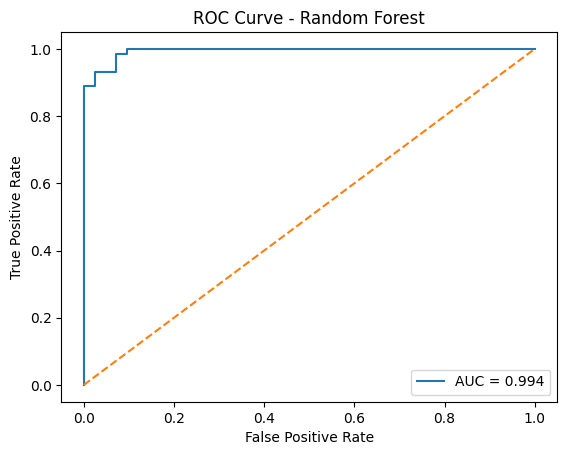

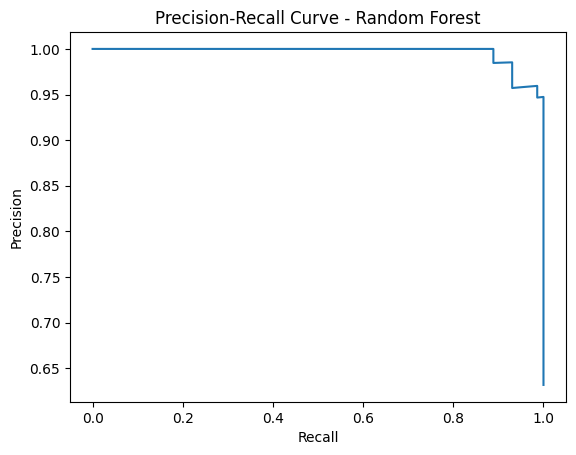

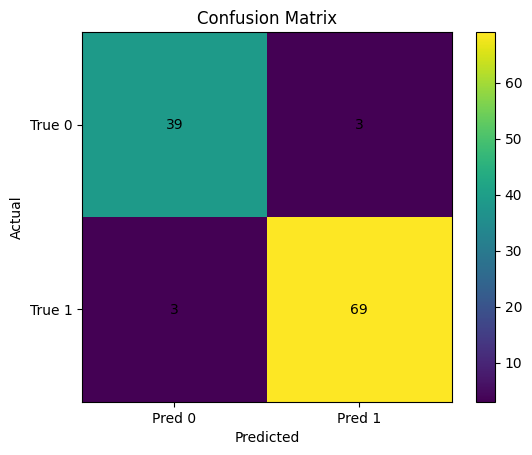

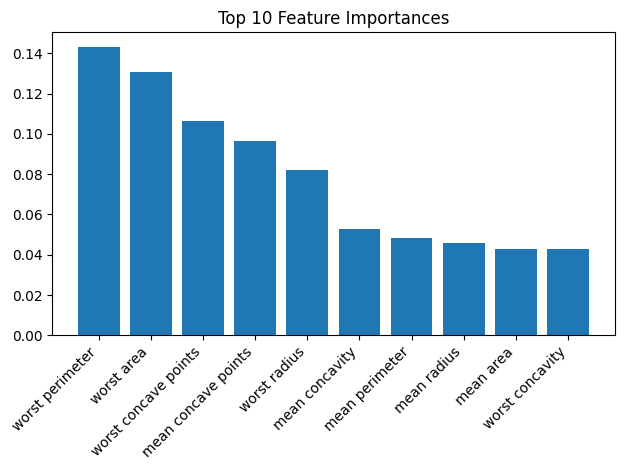

Stream accuracy: 0.9474
Latency (ms): mean=68.20, p95=69.93, p99=71.14


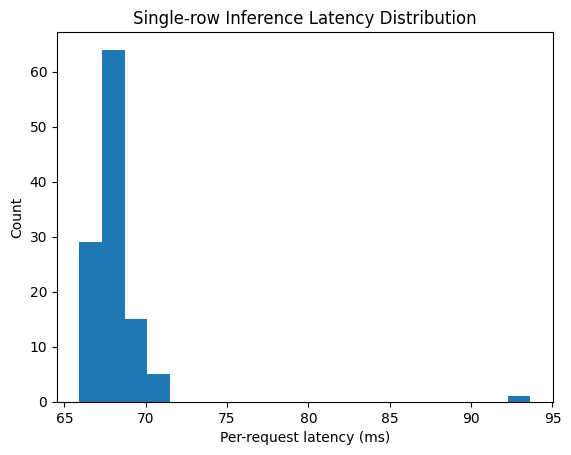

Saved model to rf_model.joblib
Reload predict OK.


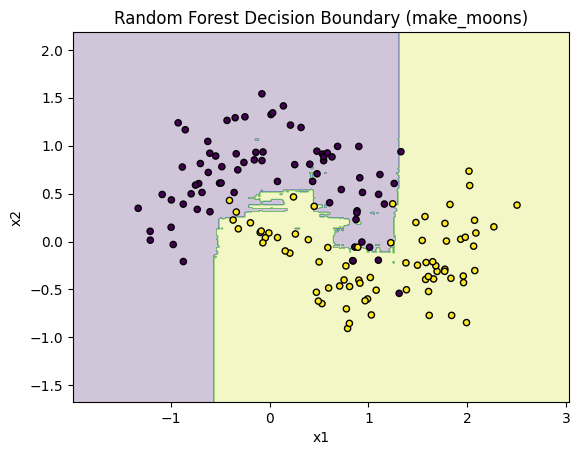

In [1]:
# Random Forest classification with visualizations + "real-time" latency sim
# -------------------------------------------------------------------------
# pip install scikit-learn matplotlib numpy joblib

import time
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.datasets import load_breast_cancer, make_moons
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix,
    classification_report, roc_curve, precision_recall_curve
)
import joblib


# ========== A) REAL DATASET (breast_cancer) + METRIC VISUALIZATIONS ==========
def run_real_dataset_demo():
    data = load_breast_cancer()
    X, y = data.data, data.target
    feature_names = data.feature_names

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("rf", RandomForestClassifier(
            n_estimators=200, class_weight="balanced",
            random_state=42, n_jobs=-1
        ))
    ])

    t0 = time.perf_counter()
    pipe.fit(X_tr, y_tr)
    train_time_ms = (time.perf_counter() - t0) * 1000

    y_pred = pipe.predict(X_te)
    y_proba = pipe.predict_proba(X_te)[:, 1]

    acc = accuracy_score(y_te, y_pred)
    f1  = f1_score(y_te, y_pred)
    auc = roc_auc_score(y_te, y_proba)
    cm  = confusion_matrix(y_te, y_pred)

    print("\n=== Offline Evaluation (Breast Cancer) ===")
    print(f"Train time: {train_time_ms:.1f} ms")
    print(f"Accuracy: {acc:.4f} | F1: {f1:.4f} | ROC AUC: {auc:.4f}")
    print("Confusion matrix:\n", cm)
    print("\nClassification report:\n", classification_report(y_te, y_pred, digits=4))

    # ---- Visualizations ----
    # ROC
    fpr, tpr, _ = roc_curve(y_te, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Random Forest"); plt.legend(); plt.show()

    # Precision-Recall
    prec, rec, _ = precision_recall_curve(y_te, y_proba)
    plt.figure()
    plt.plot(rec, prec)
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("Precision-Recall Curve - Random Forest")
    plt.show()

    # Confusion Matrix heatmap
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.xticks([0,1], ["Pred 0","Pred 1"]); plt.yticks([0,1], ["True 0","True 1"])
    plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.colorbar(); plt.show()

    # Feature importances
    rf = pipe.named_steps["rf"]
    importances = rf.feature_importances_
    top_idx = np.argsort(importances)[::-1][:10]
    plt.figure()
    plt.bar(range(len(top_idx)), importances[top_idx])
    plt.xticks(range(len(top_idx)), [feature_names[i] for i in top_idx],
               rotation=45, ha="right")
    plt.title("Top 10 Feature Importances")
    plt.tight_layout(); plt.show()

    # ---- "Real-time" single-row inference latency simulation ----
    latencies, correct = [], 0
    for i in range(len(X_te)):
        x = X_te[i].reshape(1, -1)
        t0 = time.perf_counter()
        pred = pipe.predict(x)[0]
        _ = pipe.predict_proba(x)[0, 1]
        lat = (time.perf_counter() - t0) * 1000
        latencies.append(lat)
        correct += int(pred == y_te[i])
    latencies = np.array(latencies)
    print(f"Stream accuracy: {correct/len(X_te):.4f}")
    print(f"Latency (ms): mean={latencies.mean():.2f}, "
          f"p95={np.percentile(latencies,95):.2f}, p99={np.percentile(latencies,99):.2f}")

    plt.figure()
    plt.hist(latencies, bins=20)
    plt.xlabel("Per-request latency (ms)"); plt.ylabel("Count")
    plt.title("Single-row Inference Latency Distribution")
    plt.show()

    # Save & reload example
    joblib.dump({"pipeline": pipe, "feature_names": list(feature_names)}, "rf_model.joblib")
    print("Saved model to rf_model.joblib")
    payload = joblib.load("rf_model.joblib")
    _ = payload["pipeline"].predict(np.zeros((1, len(payload["feature_names"]))))
    print("Reload predict OK.")
    return pipe


# ========== B) OPTIONAL: 2-D DECISION BOUNDARY VISUALIZATION ==========
def decision_boundary_demo():
    X, y = make_moons(n_samples=600, noise=0.25, random_state=42)

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=42
    )

    clf = RandomForestClassifier(n_estimators=300, max_depth=None,
                                 random_state=42, n_jobs=-1)
    clf.fit(X_tr, y_tr)

    # grid for boundary
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 400),
        np.linspace(y_min, y_max, 400)
    )
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.25)
    plt.scatter(X_te[:,0], X_te[:,1], c=y_te, s=20, edgecolors="k")
    plt.title("Random Forest Decision Boundary (make_moons)")
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.show()


if __name__ == "__main__":
    _ = run_real_dataset_demo()   # metrics + plots + latency
    decision_boundary_demo()      # pretty 2-D boundary plot
